In [13]:
import sys 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
sys.path.insert(0, "../../")
import spycone as spy

# Transcript-level workflow

## Prepare the dataset

The dataset is SARS-Cov-2 infection with 8 time points and 4 replicates. 

In [12]:
#sample data
import os
os.chdir("/nfs/proj/spycone/")


data = pd.read_csv("./spycone_pkg/data/covid_hs/sorted_bc_tpm.csv", sep="\t")
genelist = pd.read_csv("./spycone_pkg/data/covid_hs/genelist.csv", sep="\t")

geneid= list(map(lambda x: str(int(x)) if not np.isnan(x) else x,  genelist['gene'].tolist()))
transcriptid = genelist['isoforms'].to_list()

Read the data to the dataset function.

In [14]:
dset = spy.dataset(ts=data,
        transcript_id=transcriptid,
        gene_id = geneid,
        species=9606,
        keytype='entrezgeneid',
        timepts=4, reps1=3)

Import biological network of your choice with `BioNetwork`, Spycone provides Biogrid, IID network in entrez ID as node name. Please specify the keytype if you are using a different ID.

In [15]:
bionet = spy.BioNetwork(path="./spycone_pkg/spycone/data/network/9606_biogrid_entrez.tab")

## Preprocessing

Filtering out genes that has expression across all time points lower than 1. By giving the biological network, it removes genes from the dataset that are not in the network.

In [16]:
spy.preprocess(dset, bionet, cutoff=1)

Input data dimension: (105891, 4)
Removed 74708 objects lower than 1
Removed 8454 objects in dataset that are not in the network
Removed 607 nodes in network that are not in the dataset
Filtered data: (30576, 4)


## Detect isoform switch
iso object contains method for isoform switch detect and total isoform usage calculation.

In [17]:
iso = spy.iso_function(dset)
        #run isoform switch
ascov=iso.detect_isoform_switch(filtering=False, min_diff=0.05, corr_cutoff=0.5, event_im_cutoff=0.1, p_val_cutoff=0.05)

0 of genes with low expression are filtered out!!.
normalizing...
calculating...
----Result statistics----
Events found: 1718
Events with affecting domains: 697
Mean event importance: 0.5609657987735032
Mean difference before and after switch: 0.13359111391035303
--------------------------
DONE


`iso.detect_isoform_switch` returns a dataframe containing the metrics of all isoform switch events detected. \

`iso_ratio` : ratio of switching time to number of time points \
`diff` : difference of relative abundances before and after switch \
`p_value` : combined p-value of maj_pval and min_pval (corresponding p-value from t-test of the transcripts) \
`corr` : dissimilar correlation (inverted pearson correlation) \
`final_sp` : best switch point \
`event_importance` : the ratio of the relative abundance of the events to the highest expressed transcripts \
`exclusive_domains` : domain loss/gain of the event \
`adj_pval` : p-values after multiple test correction 

In [18]:
ascov.head()

,gene,gene_symb,major_transcript,minor_transcript,iso_ratio,diff,maj_pval,min_pval,p_value,corr,final_sp,event_importance,exclusive_domains,adj_pval
0,284349,ZNF283,ENST00000650832.1,ENST00000588967.1,0.25,0.661279,1.520499e-08,1.520499e-08,7.749961e-08,0.762199,2,0.633423,"[PF13912, PF00096]",7.749961e-08
1,284349,ZNF283,ENST00000588967.1,ENST00000650832.1,0.25,0.661279,1.520499e-08,1.520499e-08,7.749961e-08,0.762199,2,0.633423,"[PF13912, PF00096]",7.749961e-08
2,8761,PABPC4,ENST00000474378.1,ENST00000421687.6,0.25,0.067907,1.034853e-06,1.939426e-03,4.182760e-06,0.889359,3,0.627272,[PF00658],4.182190e-06
3,79184,BRCC3,ENST00000330045.12,ENST00000340647.8,0.25,0.103134,3.149206e-06,3.780506e-03,1.185255e-05,0.706246,3,0.664907,[],1.184717e-05
4,79184,BRCC3,ENST00000330045.12,ENST00000369459.6,0.25,0.222201,3.149206e-06,5.658519e-03,1.185255e-05,0.978417,3,0.528768,[],1.184717e-05


You can also plot out the genes using `switch_plot`, by provide your dataset object and the result dataframe from detect_isoform_switch. 

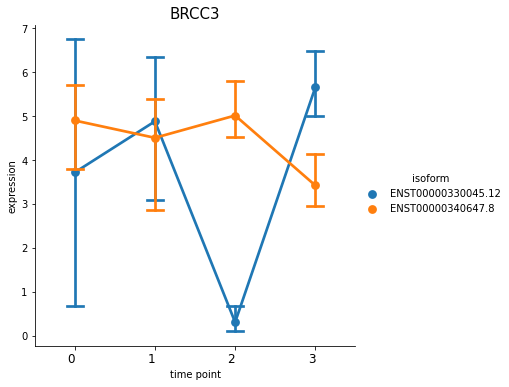

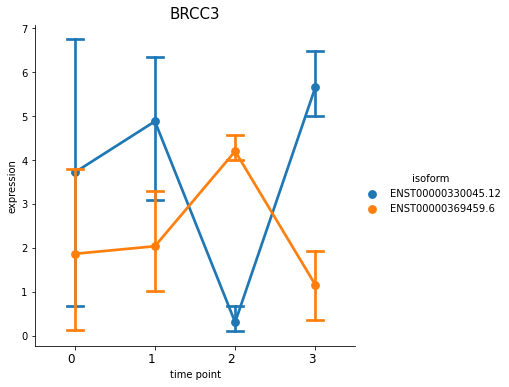

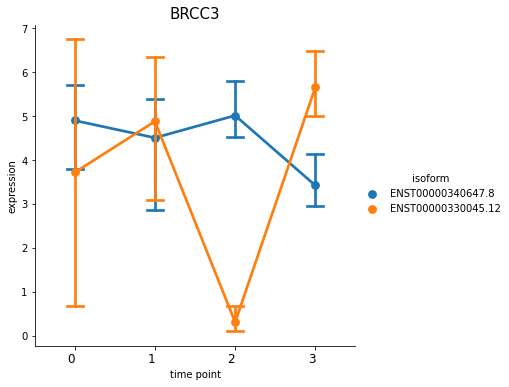

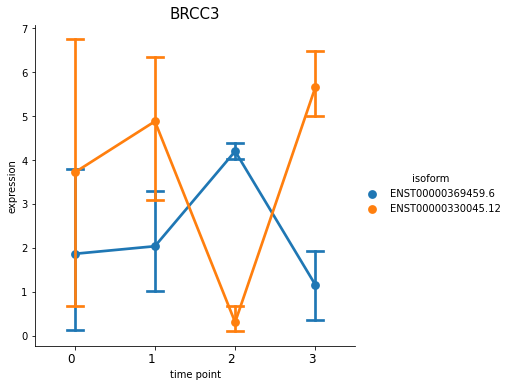

In [22]:
%matplotlib inline
spy.switch_plot("BRCC3", dset, ascov)

With this function, you can also plot all isoforms in one view, by putting `all_isoforms=True`.

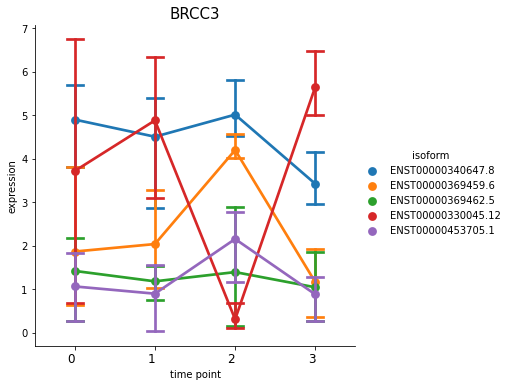

In [23]:
%matplotlib inline
spy.switch_plot("BRCC3", dset, ascov, all_isoforms=True)

## Clustering of total isoform usage

Total isoform usage measures the magnitude of change of isoform relative abundance over time. It indicates the changes due to post-transcriptional regulation (e.g. aternative splicing). You can cluster the genes with total isoform gene, thus getting groups of gene with similar patterns of change of total isoform usage over time.

In [25]:
dset = iso.total_isoform_usage(ascov, gene_level=True)

In [26]:
asclu = spy.clustering(dset, algorithm='hierarchical', metrics="euclidean", linkage="ward", input_type="isoformusage", n_clusters=8, composite=False)
c = asclu.find_clusters()

clustering took 0.10759425163269043s. 


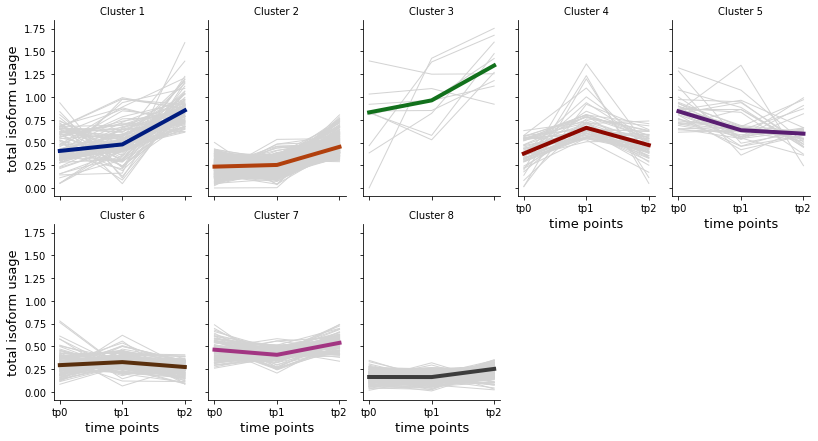

In [27]:
%matplotlib inline
spy.vis_all_clusters(asclu, col_wrap=5,y_label="total isoform usage")

## Gene set enrichment analysis

Perform gene set enrichment analysis using `clusters_gsea`. Change the gene_sets parameter into the choice of your knowledge base or gene set database, e.g. Reactome, KEGG, etc. Use `spy.list_genesets` to view the available knowledge base.

With the isoform switch detection, we can enriched the domains affect by the isoform switch events using `Nease`. 

In [ ]:
asclu_go = spy.clusters_gsea(dset, 9606, is_results=ascov, method="nease", gene_sets = ['Reactome'])

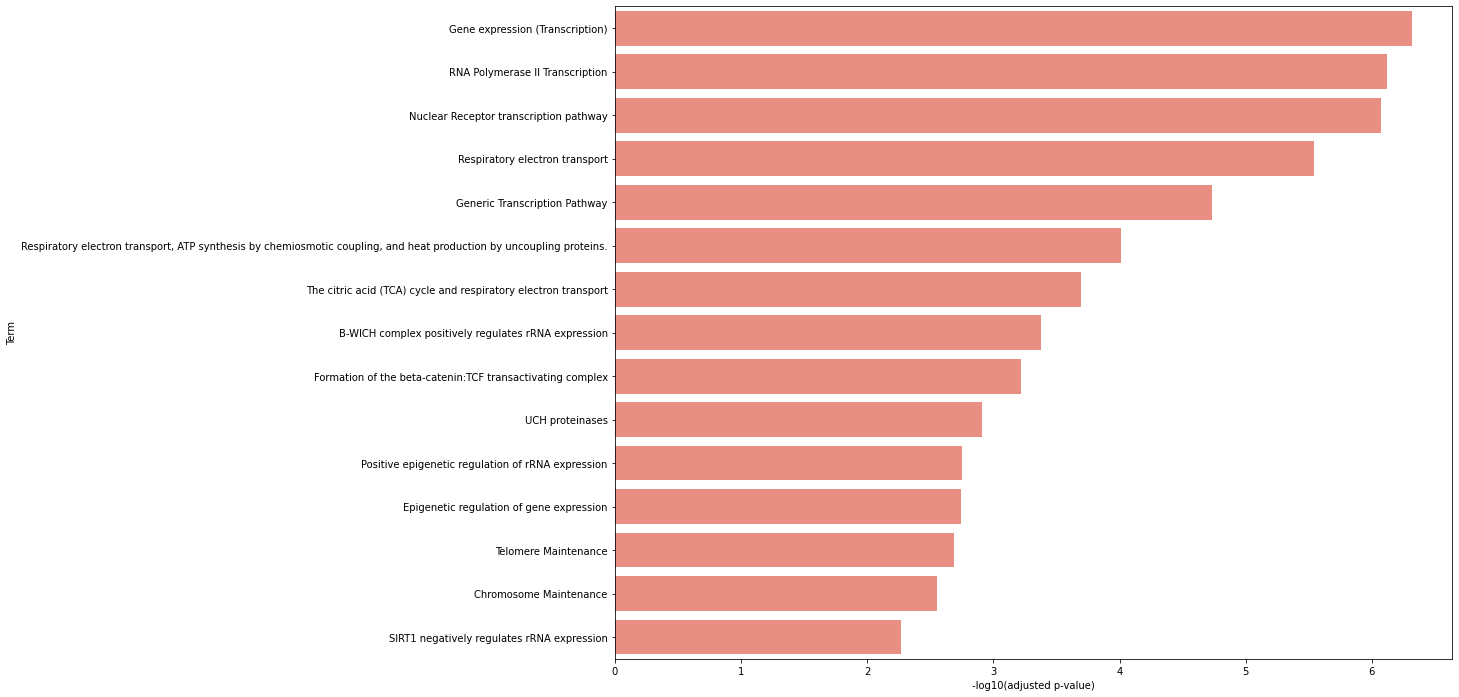

In [ ]:
%matplotlib inline
spy.gsea_plot(asclu_go, cluster=4, nterms=15)

## DOMINO on the domain level

In [ ]:
spy.run_domain_domino(asclu, is_results=ascov)

## Splicing Factor analysis